UFC Fight Prediction Using Random Forest

Overview

This project builds a UFC fight prediction model using an Sklearn Random Forest Classifier or an XGBoost Random Forest Classifier. The workflow involves data cleaning, feature engineering, hyperparameter tuning, training the model, and making predictions on new fights.

1. Load and Clean Data

Read the dataset

In [32]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
import pickle

In [33]:
# get the file path
def get_file_path(folder, file_name):
    return os.path.dirname(os.getcwd()) + "/" + folder + "/" + file_name

# read json file
def read_file(folder="data/collection/transformed", file_name=None):
    return pd.read_csv(get_file_path(folder, file_name))

training_data = read_file(file_name="training_data.csv")
training_data

,fighter_name_a,fighter_name_b,result,weight_class,event_date_a,sign_str_successful_a,sign_str_attempts_a,total_str_successful_a,total_str_attempts_a,td_successful_a,...,Win Streak_b,win_by_DEC_b,win_by_KOTKO_b,win_by_SUB_b,win_by_Other_b,loss_by_DEC_b,loss_by_DIS_b,loss_by_Other_b,loss_by_SUB_b,loss_by_KOTKO_b
0,Raulian Paiva,Kai Kara-France,b,Flyweight,2019-02-09,30.00,57.50,30.00,58.50,0.00,...,0.0,6.0,9.0,3.0,0.0,3.0,0.0,0.0,2.0,2.0
1,Alessio Di Chirico,Joaquin Buckley,a,Middleweight,2021-01-16,14.57,37.00,17.93,41.21,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Matt Hamill,Tito Ortiz,a,Light Heavyweight,2010-10-23,18.14,43.43,32.14,60.00,0.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Joaquim Silva,Ricky Glenn,b,Lightweight,2021-06-19,13.60,38.10,18.10,43.30,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Scott Smith,David Terrell,b,Middleweight,2006-04-15,9.00,13.00,10.00,14.00,0.00,...,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,Liz Carmouche,NaN,b,Women's Bantamweight,2011-03-05,20.33,34.00,49.67,68.00,1.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10327,Chael Sonnen,NaN,a,Middleweight,2006-04-06,8.00,14.50,37.00,46.00,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10328,Ryuta Sakurai,NaN,b,NaN,2005-04-03,16.00,25.00,23.00,32.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10329,Javier Vazquez,Jens Pulver,a,Featherweight,2010-03-06,11.75,41.75,18.00,48.00,0.50,...,0.0,6.0,13.0,3.0,0.0,1.0,0.0,0.0,5.0,6.0


In [35]:
training_data = training_data.dropna(subset=["fighter_name_a", "fighter_name_b","weight_class","event_date_a","event_date_b"])

training_data["Losses_a"] = training_data.Losses_a.fillna(0)

non_feature_columns = [
    "fighter_name_a",
    "fighter_name_b",
    "event_date_a",
    "event_date_b",
]

training_data = training_data[~training_data.result.str.contains("draw")]
training_data = training_data[~training_data.result.str.contains("nc")]

training_data = training_data.drop_duplicates()

# drop weight class null 
training_data = training_data.dropna(subset=["weight_class"])

training_data.fillna(0, inplace=True)

clean_training_data = training_data.copy()

clean_training_data.shape

clean_training_data

,fighter_name_a,fighter_name_b,result,weight_class,event_date_a,sign_str_successful_a,sign_str_attempts_a,total_str_successful_a,total_str_attempts_a,td_successful_a,...,Win Streak_b,win_by_DEC_b,win_by_KOTKO_b,win_by_SUB_b,win_by_Other_b,loss_by_DEC_b,loss_by_DIS_b,loss_by_Other_b,loss_by_SUB_b,loss_by_KOTKO_b
0,Raulian Paiva,Kai Kara-France,b,Flyweight,2019-02-09,30.00,57.50,30.00,58.50,0.00,...,0.0,6.0,9.0,3.0,0.0,3.0,0.0,0.0,2.0,2.0
1,Alessio Di Chirico,Joaquin Buckley,a,Middleweight,2021-01-16,14.57,37.00,17.93,41.21,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Matt Hamill,Tito Ortiz,a,Light Heavyweight,2010-10-23,18.14,43.43,32.14,60.00,0.93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Joaquim Silva,Ricky Glenn,b,Lightweight,2021-06-19,13.60,38.10,18.10,43.30,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Scott Smith,David Terrell,b,Middleweight,2006-04-15,9.00,13.00,10.00,14.00,0.00,...,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,Jon Fitch,Johny Hendricks,b,Welterweight,2011-12-30,11.03,23.83,41.53,56.80,1.23,...,0.0,4.0,6.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
10315,Pedro Munhoz,Raphael Assuncao,b,Bantamweight,2014-02-22,0.00,0.00,0.00,0.00,0.00,...,0.0,8.0,3.0,10.0,0.0,2.0,0.0,0.0,1.0,1.0
10321,Jan Blachowicz,Igor Pokrajac,a,Light Heavyweight,2016-04-10,12.20,26.60,16.40,32.00,0.20,...,0.0,4.0,15.0,9.0,0.0,4.0,0.0,0.0,2.0,6.0
10329,Javier Vazquez,Jens Pulver,a,Featherweight,2010-03-06,11.75,41.75,18.00,48.00,0.50,...,0.0,6.0,13.0,3.0,0.0,1.0,0.0,0.0,5.0,6.0


In [36]:
# transform weight class to numerical values
weight_class_encoder = LabelEncoder()
weight_class_encoder.fit(clean_training_data["weight_class"])

clean_training_data["weight_class"] = weight_class_encoder.transform(
    clean_training_data["weight_class"]
)

In [37]:
# split features and target (results)
X = clean_training_data.drop(columns=non_feature_columns)
X = X.drop(columns=["result"])
y = clean_training_data["result"]

Split features and target variable

In [38]:
# encode the target
le = LabelEncoder()
y = le.fit_transform(y)

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42
)

3. Train Model

Split data and tune hyperparameters using RandomizedSearchCV

In [39]:
# Sklearn Random Forest

param_dist = {
    "n_estimators": randint(100, 500),  # More trees improve stability
    "max_depth": randint(5, 30),  # Prevent overly deep trees
    "min_samples_split": randint(2, 20),  # Avoid overfitting small splits
    "max_features": ["sqrt", "log2", None],  # Control number of features per split
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=50,  # Increase if you have time for better tuning
    scoring="accuracy",  # We use accuracy as our metric
    random_state=42,
    n_jobs=-1,  # Use all available CPUs for efficiency
)

In [ ]:
# XGBoost Random Forest

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(5, 30),
    "learning_rate": uniform(0.01, 0.3),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 10),
    "subsample": uniform(0.5, 0.5),        # range of 0.5 to 1.0
    "colsample_bynode": uniform(0.5, 0.5), # range of 0.5 to 1.0
    "sampling_method": ["uniform", "gradient_based"],
    "reg_alpha": uniform(0, 10),
    "reg_lambda": uniform(0, 10),
}

random_search = RandomizedSearchCV(
    estimator=XGBRFClassifier(
        device="cuda",
        enable_categorical=True,
    ),
    param_distributions=param_dist,
    n_iter=50,  # Increase if you have time for better tuning
    scoring="accuracy",  # We use accuracy as our metric
    random_state=42,
    n_jobs=-1,  # Use all available CPUs for efficiency
)

In [40]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

Best Parameters: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_split': 9, 'n_estimators': 367}
Best Accuracy Score: 0.6375


Train final model with optimal parameters and evalute accuracy

In [41]:
# Sklearn Random Forest

model = RandomForestClassifier(
    n_estimators=random_search.best_params_["n_estimators"],
    max_depth=random_search.best_params_["max_depth"],
    min_samples_split=random_search.best_params_["min_samples_split"],
    max_features=random_search.best_params_["max_features"],
    random_state=42,
)

In [ ]:
# XGBoost Random Forest

model = XGBRFClassifier(
    colsample_bynode=random_search.best_params_["colsample_bynode"],
    gamma=random_search.best_params_["gamma"],
    learning_rate=random_search.best_params_["learning_rate"],
    max_depth=random_search.best_params_["max_depth"],
    min_child_weight=random_search.best_params_["min_child_weight"],
    n_estimators=random_search.best_params_["n_estimators"],
    reg_alpha=random_search.best_params_["reg_alpha"],
    reg_lambda=random_search.best_params_["reg_lambda"],
    random_state=42,
    sampling_method=random_search.best_params_["sampling_method"],
    subsample=random_search.best_params_["subsample"],
    device="cuda",
    enable_categorical=True,
)

In [42]:
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6240557815223707


***Save model***


In [43]:
# Sklearn Random Forest
file_name = "skrf_classifier.pkl"
folder="saved_models"
pickle.dump(model, open(get_file_path(folder, file_name), "wb"))

In [27]:
# XGBoost Random Forest
file_name = "xgbrf_classifier.pkl"
folder="saved_models"
pickle.dump(model, open(get_file_path(folder, file_name), "wb"))

Feature Importance Visualization

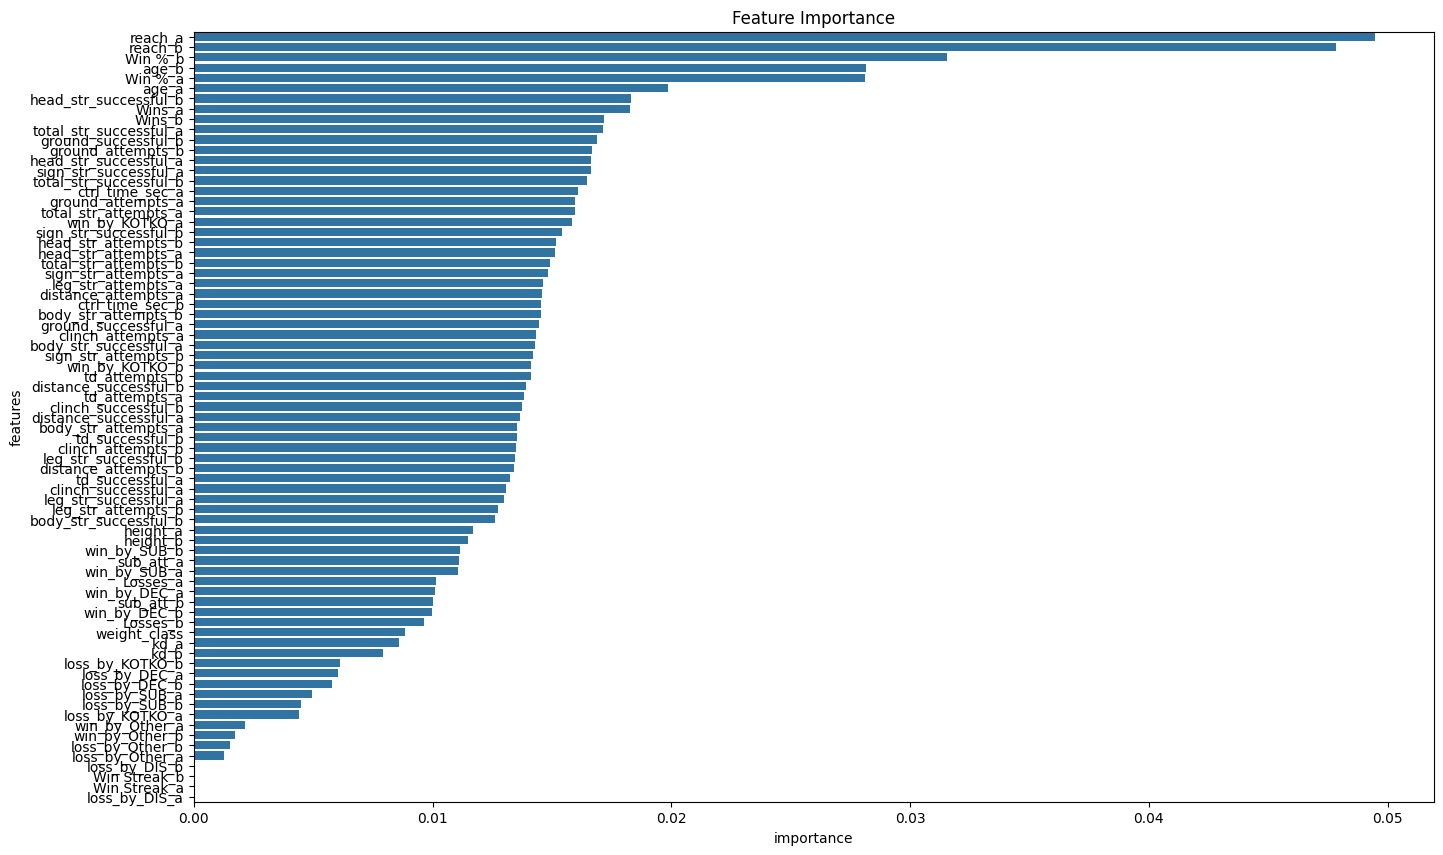

In [44]:
# Visualize the model the most important features
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
features = X.columns
df = pd.DataFrame({"features": features, "importance": feature_importances})
df = df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x=df["importance"], y=df["features"])
plt.title("Feature Importance")
plt.show()

5. Match Prediction

Prepare fighter match data

In [45]:
def df_selection(df):

    # Delete result column
    df = df.drop(columns=["result"])

    # find all columns ending with a and b
    fighter_columns = [col for col in df.columns if col.endswith("_a")]
    opponent_columns = [col for col in df.columns if col.endswith("_b")]

    # select all columns ending with a and b
    df_a, df_b = df[fighter_columns], df[opponent_columns]

    # remove the suffixes
    df_a.columns = [col[:-2] if col.endswith("_a") else col for col in df_a.columns]
    df_b.columns = [col[:-2] if col.endswith("_b") else col for col in df_b.columns]

    df = pd.concat([df_a, df_b], axis=1)

    # remove duplicate column & order by event date
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.sort_values(by="event_date", ascending=False)

    # get most recent per fighter
    df = df.drop_duplicates(subset=["fighter_name"], keep="first")

    return df

In [46]:
selection_df = df_selection(training_data)

Create fight matchup features

In [47]:
def create_match(
    selection_df: pd.DataFrame,
    fighter_a: str | list,
    fighter_b: str | list,
    weight_class: str | list
) -> pd.DataFrame:

    if isinstance(fighter_a, str):
        fighter_a = [fighter_a]
        fighter_b = [fighter_b]
        weight_class = [weight_class]

    if len(fighter_a) != len(fighter_b) or len(fighter_a) != len(weight_class):
        raise ValueError("The number of fighters and weight_classes must be the same")

    # Remove event date from the selection_df
    selection_df = selection_df.drop(columns=["event_date"])

    # get the most recent data for each fighter
    fighter_a_data = selection_df.set_index("fighter_name").loc[fighter_a].reset_index()
    fighter_b_data = selection_df.set_index("fighter_name").loc[fighter_b].reset_index()

    # rename the columns add suffixes

    fighter_a_data.columns = [f"{col}_a" for col in fighter_a_data.columns]
    fighter_b_data.columns = [f"{col}_b" for col in fighter_b_data.columns]

    # reset the index
    fighter_a_data = fighter_a_data.reset_index(drop=True)
    fighter_b_data = fighter_b_data.reset_index(drop=True)

    # merge on index
    features = pd.concat([fighter_a_data, fighter_b_data], axis=1)

    # weight class to series
    features["weight_class"] = pd.Series(weight_class)

    # transform weight class to numerical values
    features["weight_class"] = weight_class_encoder.transform(features["weight_class"])

    # weight class as first column
    features = features[
        ["weight_class"] + [col for col in features.columns if col != "weight_class"]
    ]

    return features

Predict fight outcomes

In [48]:
# Function to predict the outcome of a fight

def predict_outcome(training_data, features: pd.DataFrame) -> pd.DataFrame:

    # train model on all the data
    model = pickle.load(open(get_file_path(folder, file_name), "rb"))

    X, y = clean_training_data.drop(columns=non_feature_columns), training_data["result"]

    X = X.drop(columns=["result"])
    y = le.fit_transform(y)

    # remove fighter_name
    x = features.drop(columns=["fighter_name_a", "fighter_name_b"])

    # change x sequence to match the training data
    x = x[X.columns]

    # make predictions
    y_pred = model.predict(x)

    # add probability of the winning class
    y_pred_proba = model.predict_proba(x)
    y_pred_proba = y_pred_proba.max(axis=1)

    # if b than loss else win
    y_pred = ["loss" if result == 1 else "win" for result in y_pred]

    predictions_df = pd.DataFrame(
        {
            "Fighter": features["fighter_name_a"].values,
            "Opponent": features["fighter_name_b"].values,
            # original y values
            "Result": y_pred,
            "Vote Share": y_pred_proba,
        }
    )

    return predictions_df


features = create_match(
    selection_df,
    fighter_a=[
        "Alex Pereira",
        "Jon Jones",
        "Islam Makhachev",
        "Alexander Volkanovski",
        "Belal Muhammad",
        "Paddy Pimblett",
        "Khamzat Chimaev",
        "Leon Edwards",
    ],
    fighter_b=[
        "Magomed Ankalaev",
        "Tom Aspinall",
        "Ilia Topuria",
        "Diego Lopes",
        "Jack Della Maddalena",
        "Michael Chandler",
        "Dricus Du Plessis",
        "Sean Brady",
    ],
    weight_class=[
        "Light Heavyweight",
        "Heavyweight",
        "Lightweight",
        "Featherweight",
        "Welterweight",
        "Lightweight",
        "Middleweight",
        "Welterweight",
    ],
)


outcome = predict_outcome(training_data, features)

outcome

,Fighter,Opponent,Result,Vote Share
0,Alex Pereira,Magomed Ankalaev,loss,0.539301
1,Jon Jones,Tom Aspinall,win,0.578142
2,Islam Makhachev,Ilia Topuria,win,0.657387
3,Alexander Volkanovski,Diego Lopes,win,0.573012
4,Belal Muhammad,Jack Della Maddalena,loss,0.538755
5,Paddy Pimblett,Michael Chandler,win,0.515372
6,Khamzat Chimaev,Dricus Du Plessis,win,0.599850
7,Leon Edwards,Sean Brady,loss,0.537109
